In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
import matplotlib.dates as mdates
import seaborn as sns

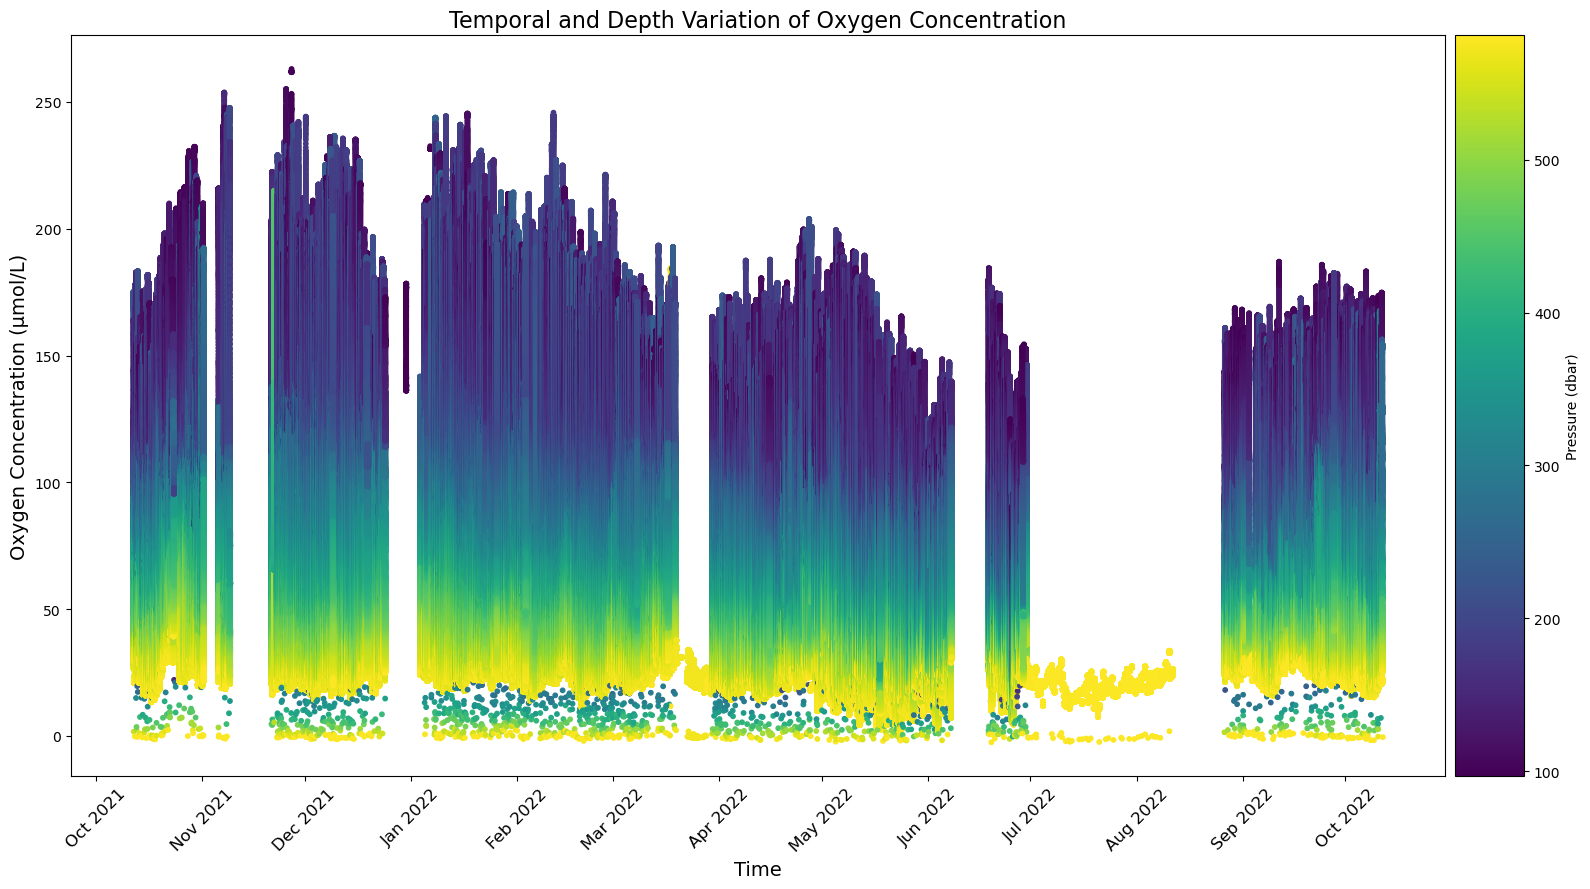

In [3]:
# Directory where your CSV files are located
directory = '/home/jovyan/Vijay.Aakriti_FinalProject/data/csvfiles(o2andepth)'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')] #OS helps perfrm tasks related to file and directory operations

# Initialize an empty list to store data
data_frames = []

# Loop through each CSV file and read the data
for csv_file in csv_files:
    file_path = os.path.join(directory, csv_file)
    data = pd.read_csv(file_path)  # Adjust the encoding as needed

    # Convert the 'time' column to datetime and handle mixed date formats
    data['time'] = pd.to_datetime(data['time'], errors='coerce', dayfirst =True)

    # Drop rows with invalid datetime values
    data = data.dropna(subset=['time'])

    # Add the data frame to the list
    data_frames.append(data)

# Combine all data frames into one
combined_data = pd.concat(data_frames)

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 9))

# Plot oxygen concentration with pressure represented by the color bar
sc = ax1.scatter(combined_data['time'], combined_data['dosta_abcdjm_cspp_tc_oxygen'], c=combined_data['int_ctd_pressure'], cmap='viridis', s=10)
ax1.set_xlabel('Time', fontsize=14)  # Increased font size for x-axis label
ax1.set_ylabel('Oxygen Concentration (µmol/L)', fontsize=14)  # Increased font size for y-axis label
ax1.set_title('Temporal and Depth Variation of Oxygen Concentration', fontsize=16)  # Increased font size for the title

# Create a color bar for pressure on the right y-axis
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sc, cax=cax, label='Pressure (dbar)')

# Configure the x-axis to show only months
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(DateFormatter("%b %Y"))

# Rotate x-axis labels for better visibility
ax1.tick_params(axis='x', which='major', labelsize=12)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/home/jovyan/project/upwellingvsO2.csv', parse_dates=['time'], dayfirst=True)

# Create a figure with a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Dissolved Oxygen on the first y-axis
ax1.scatter(df['time'], df['O2 (micromol/L)'], color='blue', marker='o', label='Dissolved Oxygen', linestyle='--')
ax1.set_xlabel('Time')  # Label for the x-axis
ax1.set_ylabel('Dissolved Oxygen (µmol/L)', color='blue')  # Label for the left y-axis
ax1.tick_params('y', colors='blue')  # Set the color for left y-axis ticks and labels

# Create a second y-axis for Upwelling Index
ax2 = ax1.twinx()  # Create a twinned y-axis sharing the same x-axis
ax2.scatter(df['time'], df['upwelling index'], color='green', marker='s', label='Upwelling Index')  # Plot Upwelling Index on the second y-axis
ax2.set_ylabel('Upwelling Index (m³/s/100m)', color='green')  # Label for the right y-axis
ax2.tick_params('y', colors='green')  # Set the color for right y-axis ticks and labels

# Format the x-axis as dates and tilt the labels
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Set major locator to months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format major ticks as abbreviated month and year
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Add grid lines
ax1.grid(True, linestyle='--', alpha=0.7)  # Add dashed grid lines to the plot

# Calculate the correlation coefficient between Dissolved Oxygen and Upwelling Index
correlation_coefficient = df['O2 (micromol/L)'].corr(df['upwelling index'])

# Add legend with correlation coefficient
lines, labels = ax1.get_legend_handles_labels()  # Get legend handles and labels for the first y-axis
lines2, labels2 = ax2.get_legend_handles_labels()  # Get legend handles and labels for the second y-axis
ax2.legend(lines + lines2, labels + labels2 + [f'Correlation: {correlation_coefficient:.2f}'], loc='upper left')  # Combine legends and add correlation coefficient

# Title above both subplots
plt.suptitle('Dissolved Oxygen vs Upwelling Index Over Time', y=1.02, fontsize=14)  # Set title above both subplots

# Show the plot
plt.show()


In [ ]:
#Specify the folder path where your CSV files are located
folder_path_sp = '/home/jovyan/project/csv_sp'

# Create empty DataFrame to store the aggregated data for profiler measurements
profiler_agg_data = pd.DataFrame()

# Process profiler data
for filename in os.listdir(folder_path_sp):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path_sp, filename)
        profiler_data = pd.read_csv(file_path)

        # Convert the 'time' column to datetime and handle mixed date formats
        profiler_data['time'] = pd.to_datetime(profiler_data['time'], errors='coerce', dayfirst=True)

        # Drop rows with invalid datetime values
        profiler_data = profiler_data.dropna(subset=['time'])

        # Convert 'dissolved_o2_profiler' column to numeric
        profiler_data['dissolved_oxygen'] = pd.to_numeric(profiler_data['dissolved_oxygen'], errors='coerce')

        # Calculate daily average and append to the aggregated DataFrame
        profiler_daily_avg = profiler_data.resample('D', on='time').mean()
        profiler_agg_data = pd.concat([profiler_agg_data, profiler_daily_avg])

# Remove rows with NaN or infinite values
profiler_agg_data = profiler_agg_data.replace([np.inf, -np.inf], np.nan).dropna()

hyoxia_threshold= 80

# Reset the index to make 'time' a regular column
profiler_agg_data_reset = profiler_agg_data.reset_index()

# Filter data for oxygen levels below or equal to the threshold
hyoxia_data = profiler_agg_data_reset[profiler_agg_data_reset['dissolved_oxygen'] <= hyoxia_threshold]

# Create a new DataFrame with time and dissolved_oxygen columns
hyoxia_df = hyoxia_data[['time', 'dissolved_oxygen']]


# Extract month from the 'time' column
hyoxia_df['month'] = hyoxia_df['time'].dt.month

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(hyoxia_df['month'], bins=range(4, 11), align='left', rwidth=0.8, color='navy')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Hypoxia Events Frequency by Month at 200m ')

# Set x-axis ticks to represent months
plt.xticks(range(4, 11), ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()



/tmp/ipykernel_62/1122764561.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  benthic_data['time'] = pd.to_datetime(benthic_data['time'], errors='coerce',dayfirst=True)


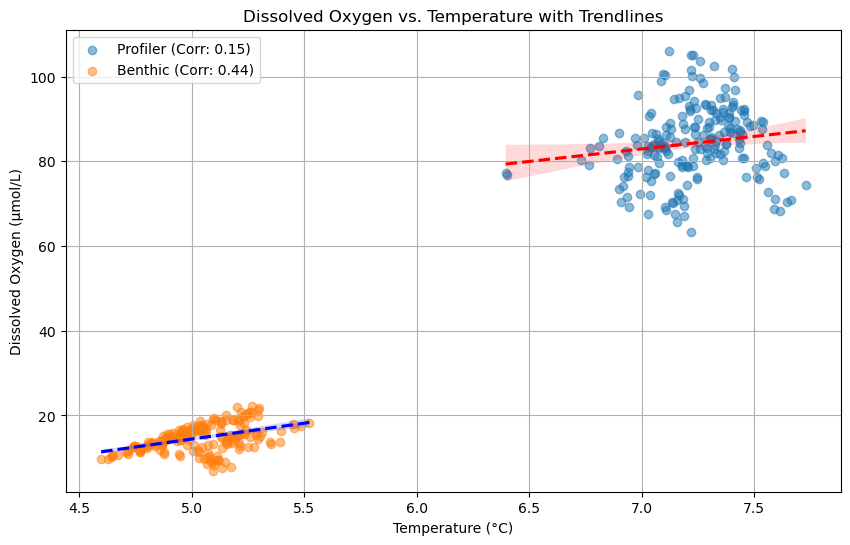

In [10]:
# Specify the folder paths where your CSV files are located
folder_path_sp = '/home/jovyan/project/csv_sp'
folder_path_benthic = '/home/jovyan/project/csv_bop'

# Create empty DataFrames to store the aggregated data for profiler and benthic measurements
profiler_agg_data = pd.DataFrame()
benthic_agg_data = pd.DataFrame()

# Process profiler data
for filename in os.listdir(folder_path_sp):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path_sp, filename)
        profiler_data = pd.read_csv(file_path)

        # Convert the 'time' column to datetime and handle mixed date formats
        profiler_data['time'] = pd.to_datetime(profiler_data['time'], errors='coerce',dayfirst=True)

        # Drop rows with invalid datetime values
        profiler_data = profiler_data.dropna(subset=['time'])

        # Convert 'dissolved_o2_profiler' and 'temperature_profiler' columns to numeric
        profiler_data['dissolved_o2_profiler'] = pd.to_numeric(profiler_data['dissolved_oxygen'], errors='coerce')
        profiler_data['temperature_profiler'] = pd.to_numeric(profiler_data['sea_water_temperature'], errors='coerce')

        # Calculate daily average and append to the aggregated DataFrame
        profiler_daily_avg = profiler_data.groupby(profiler_data['time'].dt.date).mean()
        profiler_agg_data = pd.concat([profiler_agg_data, profiler_daily_avg])

# Process benthic data
for filename in os.listdir(folder_path_benthic):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path_benthic, filename)
        benthic_data = pd.read_csv(file_path)

        # Convert the 'time' column to datetime and handle mixed date formats
        benthic_data['time'] = pd.to_datetime(benthic_data['time'], errors='coerce',dayfirst=True)

        # Drop rows with invalid datetime values
        benthic_data = benthic_data.dropna(subset=['time'])

        # Convert 'dissolved_o2_benthic' and 'temperature_benthic' columns to numeric
        benthic_data['dissolved_o2_benthic'] = pd.to_numeric(benthic_data['dissolved_oxygen'], errors='coerce')
        benthic_data['temperature_benthic'] = pd.to_numeric(benthic_data['sea_water_temperature'], errors='coerce')

        # Calculate daily average and append to the aggregated DataFrame
        benthic_daily_avg = benthic_data.groupby(benthic_data['time'].dt.date).mean()
        benthic_agg_data = pd.concat([benthic_agg_data, benthic_daily_avg])

# Remove rows with NaN or infinite values
profiler_agg_data = profiler_agg_data.replace([np.inf, -np.inf], np.nan).dropna()
benthic_agg_data = benthic_agg_data.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate correlation coefficients between temperature and dissolved oxygen for profiler and benthic measurements
corr_profiler, _ = pearsonr(profiler_agg_data['temperature_profiler'], profiler_agg_data['dissolved_o2_profiler'])
corr_benthic, _ = pearsonr(benthic_agg_data['temperature_benthic'], benthic_agg_data['dissolved_o2_benthic'])

# Plotting with seaborn
plt.figure(figsize=(10, 6))

# Plot dissolved oxygen vs temperature for profiler with a red trendline
sns.regplot(x='temperature_profiler', y='dissolved_o2_profiler', data=profiler_agg_data, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'linestyle': '--'}, label=f'Profiler (Corr: {corr_profiler:.2f})')

# Plot dissolved oxygen vs temperature for benthic with a blue trendline
sns.regplot(x='temperature_benthic', y='dissolved_o2_benthic', data=benthic_agg_data, scatter_kws={'alpha': 0.5}, line_kws={'color': 'blue', 'linestyle': '--'}, label=f'Benthic (Corr: {corr_benthic:.2f})')
#Used seaborn because sns.regplot combines scatter plots and regression lines in a single function call.
# Adding labels, title, and legend
plt.title('Dissolved Oxygen vs. Temperature with Trendlines')
plt.xlabel('Temperature (°C)')
plt.ylabel('Dissolved Oxygen (μmol/L)')
plt.legend()
plt.grid()
plt.show()
